# Designing the Controller

In this notebook, the following steps will be taken to create a controller for the CMG
* Linearize the system
* Find the eigenvalues of F for different values of K
* Pick value of K that gives negative eigenvalues for F and test in CMG

In [2]:
#importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

## Linearizing the System

In [8]:
#All the required symbols
q1,q2,v1,v2,v3,tau2,tau3 = sym.symbols('q1,q2,v1,v2,v3,tau2,tau3')

In [11]:
#Put the F function here
f = sym.Matrix([[v1],[-(5*(200*tau3*sym.sin(q2)+sym.sin(2*q2)*v1*v2+2*sym.cos(q2)*v2*v3)/(10*(sym.sin(q2))**2 -511))],[v2],[10/11 * (100*tau2 - sym.cos(q2)*v1*v3)],[-((51100*tau3+5*sym.sin(2*q2)*v2*v3+511*sym.cos(q2)*v1*v2)/(10*(sym.sin(q2))**2 -511))]])


Matrix([
[                                                                               v1],
[-(1000*tau3*sin(q2) + 5*v1*v2*sin(2*q2) + 10*v2*v3*cos(q2))/(10*sin(q2)**2 - 511)],
[                                                                               v2],
[                          90.9090909090909*tau2 - 0.909090909090909*v1*v3*cos(q2)],
[      -(51100*tau3 + 511*v1*v2*cos(q2) + 5*v2*v3*sin(2*q2))/(10*sin(q2)**2 - 511)]])

In [14]:
#Making f an executable function
f_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3), f)

<function _lambdifygenerated(q1, q2, v1, v2, v3, tau2, tau3)>

In [15]:
#Equilibrium points
#q1 is not in any of the equations, so it can be anything, let's make it about 45 degrees (desired angle)
#v3 can also be anything, but since we're starting off at 100 rpm, I'll set it as that.
q1_e = 45*np.pi/180
q2_e = 0
v1_e = 0
v2_e = 0
v3_e = 10.472 #100 rpm, starting v3
tau2_e = 0
tau3_e = 0

In [129]:
#checking if the equilibrium points work:
f_eq = f_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e)
f_eq #evaluates to 0! Nice!

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [130]:
#Now we find the Jacobians
f_jacob_x = f.jacobian([q1,q2,v1,v2,v3])
f_jacob_u = f.jacobian([tau2,tau3])

#And then we find functions for A and B using this jacobian
A_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),f_jacob_x)
B_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),f_jacob_u)

#Finally, we find the linearized state space model by evaluating A_num and B_num at the equilibrium points
A = A_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e).astype(float)
B = B_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e).astype(float)

With all these steps, we have linearized our equations of motions about the chosen equilibrium point to create a state space model.

In [131]:
A

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ,  0.20493151, -0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        , -9.52      ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ,  0.        , -0.        ]])

In [132]:
B

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 90.90909091,   0.        ],
       [  0.        , 100.        ]])

## Finding Stable Controller Gains

In [161]:
i = 0
while i == 0:
    K = np.array([[np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),0],[0,0,0,0,np.random.rand()]])
    F  = A - B@K
    s = linalg.eigvals(F)
    if (s.real <= 0).all() and (s.imag == 0).all():
        i += 1
print(K.tolist())
s

[[0.8085914584901315, 0.1356123563018472, 0.748872791294181, 0.2593557597971461, 0.0], [0.0, 0.0, 0.0, 0.0, 0.9166361309236439]]


array([-1.96998847e+01+0.j, -2.10670987e+00+0.j, -1.77120183e+00+0.j,
       -3.13077743e-16+0.j, -9.16636131e+01+0.j])

In [162]:
x0 = sym.Matrix([[0],[0],[0],[0],[10.472]])
F_sym = sym.simplify(sym.Matrix(F))
t = sym.Symbol('t')
s,V = linalg.eig(F)
Vinv = linalg.inv(V)
S = np.diag(s)
S_sym = sym.simplify(sym.Matrix(S))
V_sym = sym.simplify(sym.Matrix(V))
Vinv_sym = sym.simplify(sym.Matrix(Vinv))
x = V_sym @ sym.exp(S_sym*t) @ Vinv_sym @ x0
x = sym.simplify(x)
x_num = sym.lambdify(t, x)

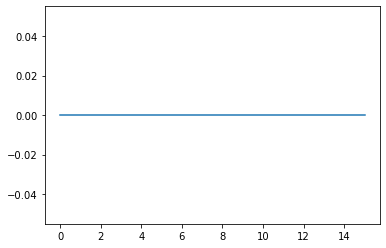

In [163]:
q = np.zeros(16)
for i in range(0,15):
    q[i] += x_num(i)[0]
plt.plot(np.linspace(0,15,16),q)